In [1]:
import pandas as pd
import numpy as np
from yahoo_fin import options
import datetime as dt
from scipy.optimize import minimize

from nelson_siegel_svensson import NelsonSiegelSvenssonCurve
from nelson_siegel_svensson.calibrate import calibrate_nss_ols


import warnings

warnings.filterwarnings("ignore")

In [2]:
def implied_vol_bisection(
    class_name,
    spot,
    strike,
    rate,
    dte,
    callprice=None,
    putprice=None,
    high=1000.0,
    low=0.0,
):
    price = 0  # Initialisation of price
    if callprice:
        price = callprice
    if putprice and not callprice:
        price = putprice
    accuracy = 1e-8  # Accuracy
    iteration = 200  # Number of iterations
    estimate = 0  # Initialisation of estimate
    mid = 0  # Initialisation of mid
    for i in range(iteration):
        mid = (high + low) / 2.0
        if mid < accuracy:
            mid = accuracy
        if callprice:
            estimate = eval(class_name)(spot, strike, rate, dte, mid).call_price
        if putprice and not callprice:
            estimate = eval(class_name)(spot, strike, rate, dte, mid).put_price
        if round(estimate, 8) == round(price, 8):
            break
        elif estimate > price:
            high = mid
        elif estimate < price:
            low = mid
    return mid

In [3]:
from scipy.special import ndtr
import scipy.stats as stats


class Option:
    def __init__(self, spot, strike, rate, time_to_maturity, volatility, dividend=None):
        self.spot = spot
        self.strike = strike
        self.rate = rate
        self.dividend = dividend
        self.time_to_maturity = time_to_maturity  # ! Year fraction
        self.volatility = volatility

    def __repr__(self) -> str:
        return f"Option Class -> Option({self.spot}, {self.strike}, {self.rate}, {self.time_to_maturity}, {self.volatility}, {self.dividend})"

    def __str__(self) -> str:
        return f"Option Class -> Option({self.spot}, {self.strike}, {self.rate}, {self.time_to_maturity}, {self.volatility}, {self.dividend})"


class BlackScholes(Option):
    """
    This is a class for Options contract for pricing European options on stocks/index without dividends.

    Attributes:
        spot          : int or float
        strike        : int or float
        rate          : float
        dte           : int or float [days to expiration in number of days]
        volatility    : float
        call_price     : int or float [default None]
        put_price      : int or float [default None]
    """

    def __init__(
        self,
        spot,
        strike,
        rate,
        time_to_maturity,
        volatility,
        dividend=None,
        call_price=None,
        put_price=None,
    ):
        super().__init__(spot, strike, rate, time_to_maturity, volatility, dividend)
        # Utility
        self.dte = time_to_maturity / 365
        self._a_ = self.volatility * self.dte**0.5
        self.call_price = call_price
        self.put_price = put_price

        if self.volatility == 0 or self.dte == 0:
            raise ZeroDivisionError("The volatility and/or days to expiration cannot be zero")

        if self.strike == 0:
            raise ZeroDivisionError("The strike price cannot be zero")
        else:
            if self.dividend is None:
                self._d1_ = (
                    np.log(self.spot / self.strike) + (self.rate + (self.volatility**2) / 2) * self.dte
                ) / self._a_
            else:
                self._d1_ = (
                    np.log(self.spot / self.strike) + (self.rate - self.dividend + (self.volatility**2) / 2) * self.dte
                ) / self._a_

        self._d2_ = self._d1_ - self._a_

        self._b_ = np.exp(-(self.rate * self.dte))
        """
        Contains all the attributes defined for the object itself. It maps the attribute name to its value.
        """
        for i in [
            "call_price",
            "put_price",
            "call_delta",
            "put_delta",
            "call_theta",
            "put_theta",
            "call_rho",
            "put_rho",
            "vega",
            "gamma",
            "implied_vol",
        ]:
            self.__dict__[i] = None

        [self.call_price, self.put_price] = self._price()
        [self.call_delta, self.put_delta] = self._delta()
        [self.call_theta, self.put_theta] = self._theta()
        [self.call_rho, self.put_rho] = self._rho()
        self.vega = self._vega()
        self.gamma = self._gamma()

    def __repr__(self) -> str:
        return f"""BlackScholes Class ->
    BlackScholes({self.spot}, {self.strike}, {self.rate}, {self.time_to_maturity}, {self.volatility}, {self.dividend}, {self.call_price}, {self.put_price})"""

    def __str__(self) -> str:
        return f"""BlackScholes Class ->
    BlackScholes({self.spot}, {self.strike}, {self.rate}, {self.time_to_maturity}, {self.volatility}, {self.dividend}, {self.call_price}, {self.put_price})"""

    # Option Price
    def _price(self):
        """Returns the option price: [Call price, Put price]"""

        if self.volatility == 0 or self.dte == 0:
            call = np.maximum(0.0, self.spot - self.strike)
            put = np.maximum(0.0, self.strike - self.spot)
        if self.dividend is None or self.dividend == 0:
            call = self.spot * ndtr(self._d1_) - self.strike * np.exp(-self.rate * self.dte) * ndtr(self._d2_)

            put = self.strike * np.e ** (-self.rate * self.dte) * ndtr(-self._d2_) - self.spot * ndtr(-self._d1_)
        else:
            time_value = np.exp(-self.rate * self.dte)
            forward_price = self.spot * np.exp((self.rate - self.dividend) * self.dte)
            call = time_value * (forward_price * ndtr(self._d1_) - self.strike * ndtr(self._d2_))
            put = time_value * (self.strike * ndtr(-self._d2_) - forward_price * ndtr(-self._d1_))
        return (call, put)

    # Option Delta
    def _delta(self):
        """Returns the option delta: [Call delta, Put delta]"""
        call = ndtr(self._d1_)
        put = -ndtr(-self._d1_)
        return (call, put)

    # Option Gamma
    def _gamma(self):
        """Returns the option gamma"""
        return stats.norm.pdf(self._d1_) / (self.spot * self._a_)

    # Option Vega
    def _vega(self):
        """Returns the option vega"""
        if self.volatility == 0 or self.dte == 0:
            return 0.0
        else:
            return self.spot * stats.norm.pdf(self._d1_) * self.dte**0.5 / 100

    # Option Theta
    def _theta(self):
        """Returns the option theta: [Call theta, Put theta]"""
        call = -self.spot * stats.norm.pdf(self._d1_) * self.volatility / (
            2 * self.dte**0.5
        ) - self.rate * self.strike * self._b_ * ndtr(self._d2_)

        put = -self.spot * stats.norm.pdf(self._d1_) * self.volatility / (
            2 * self.dte**0.5
        ) + self.rate * self.strike * self._b_ * ndtr(-self._d2_)
        return (call / 365, put / 365)

    # Option Rho
    def _rho(self):
        """Returns the option rho: [Call rho, Put rho]"""
        call = self.strike * self.dte * self._b_ * ndtr(self._d2_) / 100
        put = -self.strike * self.dte * self._b_ * ndtr(-self._d2_) / 100
        return (call, put)

### Load the data from csv file


In [4]:
vix_data = pd.read_csv(
    r"C:\Users\rrenard\OneDrive - Arkus\Desktop\UnderlyingOptionsEODQuotes_2016-06-01.csv", index_col=1
)

In [5]:
vix_data

,underlying_symbol,root,expiration,strike,option_type,close,option_price(mid),active_underlying_price_1545,implied_volatility_1545,delta_1545,gamma_1545,theta_1545,vega_1545,rho_1545,bid_eod,ask_eod
quote_date,,,,,,,,,,,,,,,,
01/06/2016,^VIX,VIX,08/06/2016,10.0,C,0.0,4.600,14.24,0.0200,1.0000,0.0000,-0.0001,0.0000,0.1846,4.40,4.80
01/06/2016,^VIX,VIX,08/06/2016,10.0,P,0.0,0.025,14.24,1.4464,-0.0219,0.0183,-0.0111,0.0010,-0.0064,0.00,0.05
01/06/2016,^VIX,VIX,08/06/2016,10.5,C,0.0,4.100,14.24,0.0200,1.0000,0.0000,-0.0001,0.0000,0.1939,3.90,4.30
01/06/2016,^VIX,VIX,08/06/2016,10.5,P,0.0,0.025,14.24,1.2833,-0.0245,0.0226,-0.0108,0.0011,-0.0071,0.00,0.05
01/06/2016,^VIX,VIX,08/06/2016,11.0,C,0.0,3.600,14.24,0.0200,1.0000,0.0000,-0.0001,0.0000,0.2031,3.40,3.80
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
01/06/2016,^VIX,VIX,16/11/2016,60.0,P,0.0,40.250,14.24,0.7997,-0.9623,0.0077,-0.0019,0.0110,-27.2363,40.10,40.40
01/06/2016,^VIX,VIX,16/11/2016,65.0,C,0.0,0.100,14.24,0.8083,0.0287,0.0061,-0.0021,0.0088,0.2141,0.05,0.15
01/06/2016,^VIX,VIX,16/11/2016,65.0,P,0.0,45.200,14.24,0.8022,-0.9725,0.0059,-0.0012,0.0085,-29.6028,45.10,45.30


In [6]:
df = vix_data[["expiration", "strike", "option_type", "option_price(mid)", "active_underlying_price_1545", "implied_volatility_1545"]]

In [7]:
# convert expiration to datetime
df["expiration"] = pd.to_datetime(df["expiration"], format="%d/%m/%Y")
df.index = pd.to_datetime(df.index, format="%d/%m/%Y")

In [8]:
# time difference between the option expiration and Quote date
df["time_to_maturity (days)"] = (df["expiration"] - df.index).dt.days

In [9]:
yield_rate = np.array([
    0.2953,
    0.2953,
    0.3034,
    0.3506,
    0.3985,
    0.4208,
    0.4638,
    0.519,
    0.5693,
    0.6218,
    0.6611,
    0.6978,
    0.7331,
    0.7651,
    0.7951,
    0.8231,
    0.8497,
    0.8763,
    0.903,
    0.9285,
    0.953,
    0.9757,
    0.9968,
    1.0164,
    1.0346,
    1.053,
    1.0714,
    1.0895,
    1.1069,
    1.1249,
    1.1435,
    1.1611,
    1.1778,
    1.1958,
    1.2135,
    1.2307,
    1.2481,
    1.2653,
    1.2827,
    1.2998,
    1.3164,
    1.3334,
    1.3505,
    1.3674,
    1.3837,
    1.4006,
    1.5245,
    1.6465,
    1.7805,
    1.8492,
    1.8792,
    1.8657,
    1.8348,
]) / 100
yield_maturity = np.array([
    0,
    1,
    2,
    9,
    33,
    63,
    96,
    187,
    275,
    369,
    460,
    551,
    642,
    733,
    824,
    915,
    1006,
    1097,
    1189,
    1280,
    1371,
    1463,
    1555,
    1646,
    1736,
    1828,
    1920,
    2011,
    2101,
    2193,
    2287,
    2378,
    2466,
    2560,
    2651,
    2742,
    2833,
    2924,
    3016,
    3107,
    3197,
    3289,
    3381,
    3472,
    3562,
    3654,
    4387,
    5480,
    7307,
    9133,
    10960,
    14614,
    18264,
]) / 365.25

In [10]:
# NSS model calibrate
curve_fit, status = calibrate_nss_ols(yield_maturity, yield_rate)

curve_fit

NelsonSiegelSvenssonCurve(beta0=0.02175590034895772, beta1=-0.01812327051789548, beta2=-0.004036197163428514, beta3=-0.012054932231074313, tau1=2.0, tau2=5.0)

In [11]:
df['maturity in years'] = df['time_to_maturity (days)'] / 365.25

In [12]:
df['rate'] = df['maturity in years'].apply(curve_fit)  # type: ignore

In [13]:
df_call = df[df['option_type'] == 'C']
df_put = df[df['option_type'] == 'P']

In [14]:
df_call

,expiration,strike,option_type,option_price(mid),active_underlying_price_1545,implied_volatility_1545,time_to_maturity (days),maturity in years,rate
quote_date,,,,,,,,,
2016-06-01,2016-06-08,10.0,C,4.600,14.24,0.0200,7,0.019165,0.003677
2016-06-01,2016-06-08,10.5,C,4.100,14.24,0.0200,7,0.019165,0.003677
2016-06-01,2016-06-08,11.0,C,3.600,14.24,0.0200,7,0.019165,0.003677
2016-06-01,2016-06-08,11.5,C,3.125,14.24,0.5022,7,0.019165,0.003677
2016-06-01,2016-06-08,12.0,C,2.625,14.24,0.0200,7,0.019165,0.003677
...,...,...,...,...,...,...,...,...,...
2016-06-01,2016-11-16,50.0,C,0.275,14.24,0.7902,168,0.459959,0.004645
2016-06-01,2016-11-16,55.0,C,0.175,14.24,0.7839,168,0.459959,0.004645
2016-06-01,2016-11-16,60.0,C,0.125,14.24,0.7911,168,0.459959,0.004645


### Implied volatility calculation

In [15]:
df_call['implied_volatility_bisection'] = df_call.apply(lambda x: implied_vol_bisection("BlackScholes", x['active_underlying_price_1545'], x['strike'], x['rate'], x['time_to_maturity (days)'], callprice=x['option_price(mid)']), axis=1)

In [16]:
df_call['implied_volatility_bisection'] = round(df_call['implied_volatility_bisection'], 5)

In [30]:
df_call_15_70 = df_call[(df_call['strike'] >= 15) & (df_call['strike'] <= 35)]
df_calc = df[(df['strike'] >= 15) & (df['strike'] <= 35)]

In [36]:
df_calc

,expiration,strike,option_type,option_price(mid),active_underlying_price_1545,implied_volatility_1545,time_to_maturity (days),maturity in years,rate
quote_date,,,,,,,,,
2016-06-01,2016-06-08,15.0,C,0.450,14.24,0.7666,7,0.019165,0.003677
2016-06-01,2016-06-08,15.0,P,0.825,14.24,0.7666,7,0.019165,0.003677
2016-06-01,2016-06-08,16.0,C,0.225,14.24,0.9172,7,0.019165,0.003677
2016-06-01,2016-06-08,16.0,P,1.625,14.24,0.9173,7,0.019165,0.003677
2016-06-01,2016-06-08,17.0,C,0.125,14.24,0.9720,7,0.019165,0.003677
...,...,...,...,...,...,...,...,...,...
2016-06-01,2016-11-16,30.0,P,11.500,14.24,0.7325,168,0.459959,0.004645
2016-06-01,2016-11-16,32.5,C,1.000,14.24,0.7338,168,0.459959,0.004645
2016-06-01,2016-11-16,32.5,P,13.750,14.24,0.7341,168,0.459959,0.004645


In [34]:
df_call_pivot = df_call_15_70.pivot_table(index='time_to_maturity (days)', columns='strike', values='option_price(mid)')
df_calc_pivot = df_calc.pivot_table(index='time_to_maturity (days)', columns='strike', values='option_price(mid)')

In [35]:
df_calc_pivot

strike,15.0,16.0,17.0,18.0,19.0,20.0,21.0,22.0,23.0,24.0,25.0,26.0,27.0,28.0,29.0,30.0,32.5,35.0
time_to_maturity (days),,,,,,,,,,,,,,,,,,
7,0.6375,0.9250,1.3125,1.7750,2.2375,2.7125,3.2125,3.7125,4.2125,4.7125,5.2125,5.7125,6.1875,6.6875,7.1875,7.6875,8.9625,10.2125
14,0.8125,0.9625,1.2750,1.6125,2.0500,2.5250,2.9875,3.4625,3.9375,4.4375,4.9375,5.4375,5.9375,6.3875,6.8875,7.3875,8.6375,9.8875
21,1.1250,1.2250,1.4750,1.7750,2.1250,2.5375,2.9875,3.4125,3.8875,4.3625,4.8125,5.3000,5.7875,6.2875,6.7750,7.2750,8.5250,9.7375
28,1.3250,1.3625,1.5625,1.8625,2.1750,2.5625,2.9625,3.3625,3.8125,4.2625,4.6875,5.1625,5.6500,6.1125,6.5875,7.0875,8.3125,9.5250
49,1.9000,1.8500,1.9250,2.0750,2.3125,2.5750,2.9000,3.2500,3.6125,4.0000,4.4000,4.8125,5.2500,5.6750,6.1500,6.5750,7.7250,8.9125
77,2.3250,2.2750,2.3250,2.4500,2.6500,2.8500,3.1375,3.4500,3.7500,4.1250,4.4875,4.8500,5.2500,5.6625,6.0875,6.5375,7.6125,8.7625
112,2.7250,2.6500,2.6750,2.7500,2.9000,3.1000,3.3250,3.6000,3.8875,4.2000,4.5375,4.8875,5.2500,5.6375,6.0375,6.4500,7.4750,8.5500
140,3.0000,2.9000,2.9000,2.9500,3.0750,3.2250,3.4250,3.6750,3.9250,4.2250,4.5500,4.8625,5.2125,5.6000,5.9625,6.3500,7.3625,8.4250
168,3.1250,3.0250,3.0250,3.0875,3.2125,3.3750,3.5750,3.7875,4.0375,4.3250,4.6375,4.9250,5.2750,5.6250,5.9750,6.3875,7.3750,8.4375


### Quantlib Heston model calibration + pricing

In [24]:
import QuantLib as ql
import math
import numpy as np

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize']=(15,7)
plt.style.use("dark_background")
from matplotlib import cm

In [25]:
day_count = ql.Actual365Fixed()
calendar = ql.UnitedStates(m=1)
expiration_dates = [ql.Date(date.day, date.month, date.year) for date in df_calc['expiration'].unique()]
calculation_date = ql.Date(31, 5, 2016)
spot = 14.24
ql.Settings.instance().evaluationDate = calculation_date

In [29]:
dividend_yield = ql.QuoteHandle(ql.SimpleQuote(0.0))
risk_free_rate = 0.003677
dividend_rate = 0.00
flat_ts = ql.YieldTermStructureHandle(ql.ForwardCurve(expiration_dates, np.array(df_calc['rate'].unique()), day_count))
# flat_ts = ql.YieldTermStructureHandle(ql.FlatForward(calculation_date, risk_free_rate, day_count))
dividend_ts = ql.YieldTermStructureHandle(ql.FlatForward(calculation_date, dividend_rate, day_count))

In [79]:
# expiration_dates = [ql.Date(date.day, date.month, date.year) for date in df_call_15_70['expiration'].unique()]
strikes = df_calc.columns.tolist()
data = df_calc.values.tolist()
implied_vols = ql.Matrix(len(strikes), len(expiration_dates))


In [59]:
expiration_dates

[Date(8,6,2016),
 Date(15,6,2016),
 Date(22,6,2016),
 Date(29,6,2016),
 Date(20,7,2016),
 Date(17,8,2016),
 Date(21,9,2016),
 Date(19,10,2016),
 Date(16,11,2016)]

In [60]:
for i in range(implied_vols.rows()):
    for j in range(implied_vols.columns()):
        implied_vols[i][j] = data[j][i]
black_var_surface = ql.BlackVarianceSurface(
    calculation_date, calendar,
    expiration_dates, strikes,
    implied_vols, day_count)

In [61]:
strikes_grid = np.arange(strikes[0], strikes[-1],5)
expiry = 168/365.25 # years
implied_vols = [black_var_surface.blackVol(expiry, s, True)
                for s in strikes_grid] # can interpolate here
actual_data = data[-1] # cherry picked the data for given expiry (1 year)

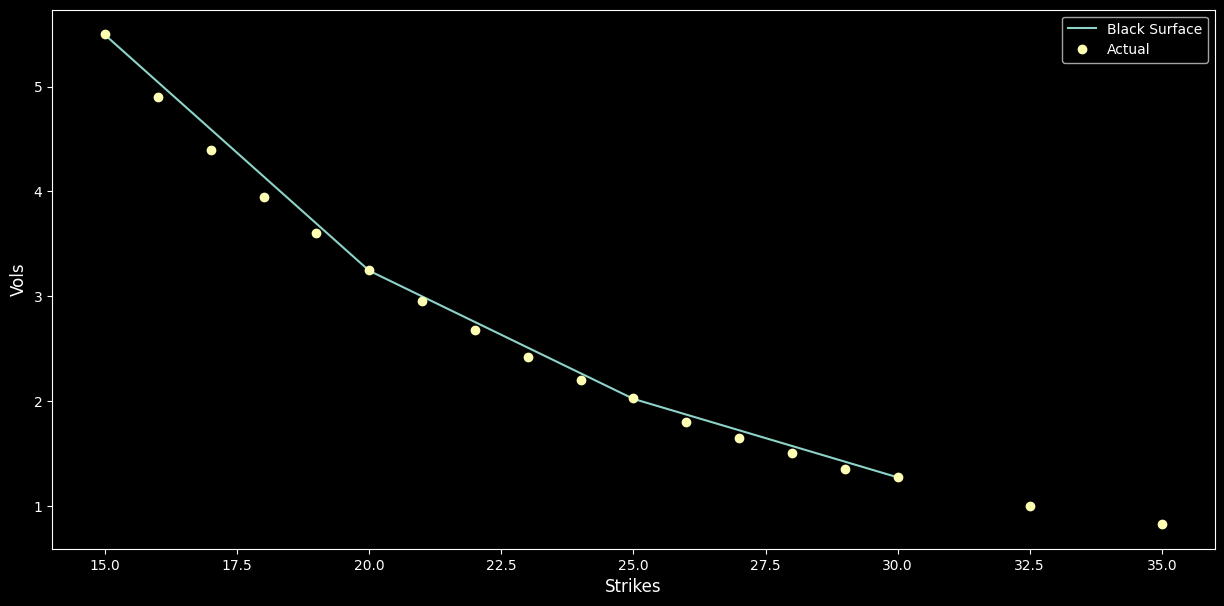

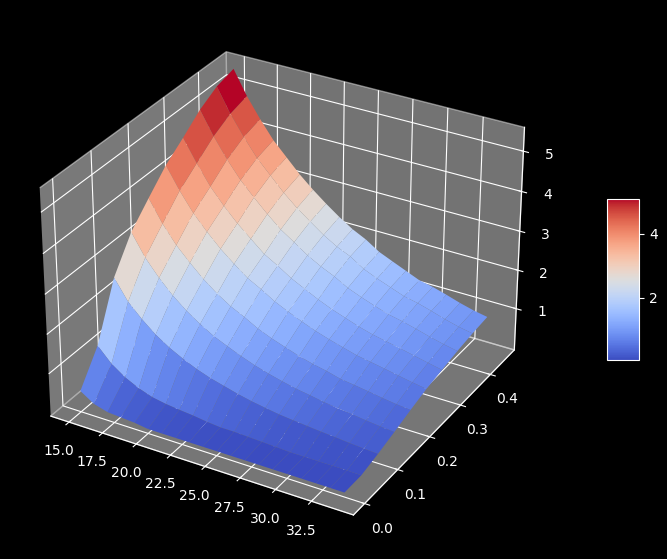

In [62]:
fig, ax = plt.subplots()
ax.plot(strikes_grid, implied_vols, label="Black Surface")
ax.plot(strikes, actual_data, "o", label="Actual")
ax.set_xlabel("Strikes", size=12)
ax.set_ylabel("Vols", size=12)
legend = ax.legend(loc="upper right")
plot_years = np.arange(0, 0.5, 0.05)
plot_strikes = np.arange(15.0, 35.0, 1.0)
fig = plt.figure()

ax = fig.add_subplot(projection='3d')
X, Y = np.meshgrid(plot_strikes, plot_years)

Z = np.array([black_var_surface.blackVol(y, x)
              for xr, yr in zip(X, Y)
                  for x, y in zip(xr,yr) ]
             ).reshape(len(X), len(X[0]))

surf = ax.plot_surface(X,Y,Z, rstride=1, cstride=1, cmap=cm.coolwarm,
                linewidth=0.1)
fig.colorbar(surf, shrink=0.3, aspect=5)

plt.show()

In [74]:
expiration_dates[-1]

Date(16,11,2016)

In [75]:
# dummy parameters
v0 = 0.01; kappa = 0.2; theta = 0.02; rho = -0.75; sigma = 0.5;

process = ql.HestonProcess(flat_ts, dividend_ts,
                           ql.QuoteHandle(ql.SimpleQuote(spot)),
                           v0, kappa, theta, sigma, rho)
model = ql.HestonModel(process)
engine = ql.AnalyticHestonEngine(model)
heston_helpers = []
black_var_surface.setInterpolation()
black_var_surface.enableExtrapolation()
date = ql.Date(16, 11, 2016)
for j, s in enumerate(strikes):
    t = (date - calculation_date )
    p = ql.Period(t, ql.Days)
    #sigma = data[one_year_idx][j]
    sigma = black_var_surface.blackVol(t/365.25, s)
    helper = ql.HestonModelHelper(p, calendar, spot, s,
                                  ql.QuoteHandle(ql.SimpleQuote(sigma)),
                                  flat_ts,
                                  dividend_ts)
    helper.setPricingEngine(engine)
    heston_helpers.append(helper)
lm = ql.LevenbergMarquardt(1e-8, 1e-8, 1e-8)
model.calibrate(heston_helpers, lm,
                 ql.EndCriteria(500, 50,
                                1.0e-8,1.0e-8,
                                1.0e-8))
theta, kappa, sigma, rho, v0 = model.params()



RuntimeError: time (0.671233) is past max curve time (0.441096)

In [70]:
print ("\ntheta = %f, kappa = %f, sigma = %f, rho = %f, v0 = %f" % (theta, kappa, sigma, rho, v0))
avg = 0.0

print ("%15s %15s %15s %20s" % (
    "Strikes", "Market Value",
     "Model Value", "Relative Error (%)"))
print ("="*70)
for i, opt in enumerate(heston_helpers):
    err = (opt.modelValue()/opt.marketValue() - 1.0)
    print ("%15.2f %14.5f %15.5f %20.7f " % (
        strikes[i], opt.marketValue(),
        opt.modelValue(),
        100.0*(opt.modelValue()/opt.marketValue() - 1.0)))
    avg += abs(err)
avg = avg*100.0/len(heston_helpers)
print ("-"*70)
print ("Average Abs Error (%%) : %5.3f" % (avg))


theta = 0.014410, kappa = 0.000004, sigma = 0.574960, rho = -0.352700, v0 = 0.012013
        Strikes    Market Value     Model Value   Relative Error (%)
          15.00       12.56392         0.08600          -99.3154978 
          16.00       11.78004         0.02961          -99.7486317 
          17.00       10.83594         0.01187          -99.8904989 
          18.00        9.88245         0.00508          -99.9486117 
          19.00        8.88910         0.00228          -99.9743500 
          20.00        7.90637         0.00107          -99.9865135 
          21.00        6.82124         0.00052          -99.9924187 
          22.00        5.99350         0.00026          -99.9956751 
          23.00        5.03768         0.00013          -99.9973422 
          24.00        4.23744         0.00007          -99.9983223 
          25.00        3.43092         0.00004          -99.9988716 
          26.00        2.72828         0.00002          -99.9992090 
          27.00  